In [1]:
import pandas as pd
import numpy as np
from seffaflik.elektrik.piyasalar import dgp, gop
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve
from datetime import datetime, timedelta
from seffaflik.elektrik import uretim
from sklearn import metrics
import requests
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import json
from lightgbm.sklearn import LGBMClassifier

In [2]:
#%% Initialize LightGBMClassifier

def LGBClassifier(X_train,y_train,X_test):
    
    space = {'learning_rate': [0.01, 0.1, 0.2, 0.3],
             'max_depth': np.arange(2, 20, 5),
             'n_estimators': np.arange(5, 100, 20),
             'num_leaves': np.arange(5, 50, 10),
             'reg_lambda': [0.0, 1.0]
             }
    gsearch1 = GridSearchCV(estimator = LGBMClassifier(), param_grid = space, n_jobs=-1, scoring='accuracy')
    gsearch1.fit(X_train,y_train)
    Xgbpred = gsearch1.predict(X_test)    
    return gsearch1, Xgbpred

In [3]:
#%% Initialize ConfusionMatrix

def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_val, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Normal','Fraud']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))

In [4]:
#%% Initialize AUC

def plot_aucprc(classifier, scores):
    precision, recall, _ = precision_recall_curve(y_val, scores, pos_label=0)
    average_precision = average_precision_score(y_val, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()


In [5]:
#%%####################################
############ DATA CURATION ############
#######################################

start = pd.to_datetime('2019-03-05')
end = pd.to_datetime('2021-05-05')
rng = pd.date_range(start, end, freq='H')
len(rng)
rng = rng[0:-1]
len(rng)
rng = pd.DataFrame(rng)
rng = rng.set_axis(['DateTime'], axis=1)

#%% Wind Forecast
def EPIAS_API():
    down = './test.json'
    url = 'https://seffaflik.epias.com.tr/transparency/service/production/wpp-generation-and-forecast?endDate=2021-12-31&startDate=2019-03-05'
    outpath=down
    generatedURL=url
    response = requests.get(generatedURL)
    if response.status_code == 200:
        with open(outpath, "wb") as out:
            for chunk in response.iter_content(chunk_size=128):
                out.write(chunk)
    with open(down) as json_file:
        data = json.load(json_file)
        
    body=data.get('body')
    gen=body.get('data')
    df=pd.DataFrame(gen)
    return df

df1 = EPIAS_API()

In [6]:
#%% System Direction

smf1 = dgp.smf(baslangic_tarihi = '2019-03-05', bitis_tarihi = '2021-05-04')
smf1['DateTime'] = pd.to_datetime(smf1.Tarih) + smf1.Saat.astype('timedelta64[h]')
smf1 = smf1.set_index('DateTime')

dictionary = {"YAL" : 1, "DNG" : np.nan, "YAT" : 0}
smf1 = smf1.replace({'Sistem Yönü': dictionary})
smf1 = smf1.drop(['Tarih','Saat','SMF'], axis = 1)

smf1 = pd.merge(smf1, rng, on="DateTime", how="outer")

In [7]:
#%% Electricity Prices

ptf1 = gop.ptf(baslangic_tarihi = '2019-03-05', bitis_tarihi = '2021-05-04')
ptf1['DateTime'] = pd.to_datetime(ptf1.Tarih) + ptf1.Saat.astype('timedelta64[h]')
ptf1 = ptf1.set_index('DateTime')
ptf1 = pd.DataFrame(ptf1['PTF'])

In [8]:
#%% Final Daily Production

kgup2 = uretim.kgup(baslangic_tarihi = '2019-03-05', bitis_tarihi = '2021-05-04')
kgup2['DateTime'] = pd.to_datetime(kgup2.Tarih) + kgup2.Saat.astype('timedelta64[h]')
kgup2 = kgup2.set_index('DateTime')
kgup2 = pd.DataFrame(kgup2['Toplam'])

In [9]:
#%% Available Installed Capacity

eak2 = uretim.eak(baslangic_tarihi = '2019-03-05', bitis_tarihi = '2021-05-04')
eak2['DateTime'] = pd.to_datetime(eak2.Tarih) + eak2.Saat.astype('timedelta64[h]')
eak2 = eak2.set_index('DateTime')
eak2 = pd.DataFrame(eak2['Toplam'])

In [10]:
#%% Merging

df = pd.merge(smf1, ptf1, on="DateTime", how="outer")
df = pd.merge(df, kgup2, on="DateTime", how="outer")
df = pd.merge(df, eak2, on="DateTime", how="outer")

In [11]:
#%% Adding Day Information

df['hour'] = pd.DatetimeIndex(df['DateTime']).hour
df['day'] = pd.DatetimeIndex(df['DateTime']).day
df['month'] = pd.DatetimeIndex(df['DateTime']).month
df['dayofweek'] = pd.DatetimeIndex(df['DateTime']).dayofweek

In [12]:
#%% Supply Demand

supplydemand = pd.read_excel('YönTahminVerisi.xlsx',index_col='DateTime',parse_dates=True)
supplydemand = supplydemand.loc['2019-03-05':'2021-05-04']
supplydemand = supplydemand.drop(['wind','ptf','smf','temp','gun_tipi','pbs'], axis = 1)
supplydemand = supplydemand.reset_index(drop=False)

df = pd.merge(df, supplydemand, on="DateTime", how="outer")

In [13]:
"""Analyzing missing values in values"""
print(df.shape)
df.isnull().sum()
df = df.dropna(axis='rows')
print(df.shape)

(19008, 11)
(18172, 11)


Index(['DateTime', 'Sistem Yönü', 'PTF', 'Toplam_x', 'Toplam_y', 'hour', 'day',
       'month', 'dayofweek', 'demand', 'supply'],
      dtype='object')
1.0    10548
0.0     7624
Name: Sistem Yönü, dtype: int64
The categorical variables are : []
There are 11 numerical variables

The numerical variables are : ['DateTime', 'Sistem Yönü', 'PTF', 'Toplam_x', 'Toplam_y', 'hour', 'day', 'month', 'dayofweek', 'demand', 'supply']


,DateTime,Sistem Yönü,PTF,Toplam_x,Toplam_y,hour,day,month,dayofweek,demand,supply
0,2019-03-05 00:00:00,0.0,288.48,29266.73,57640.72,0,5,3,1,31900,29266.73
1,2019-03-05 01:00:00,0.0,290.49,26959.48,57743.55,1,5,3,1,29800,26959.48
5,2019-03-05 05:00:00,0.0,299.98,25721.17,58270.17,5,5,3,1,28300,25721.17
6,2019-03-05 06:00:00,0.0,287.49,26618.48,58254.69,6,5,3,1,29900,26618.48
7,2019-03-05 07:00:00,0.0,320.60,28700.24,58006.07,7,5,3,1,31800,28700.24


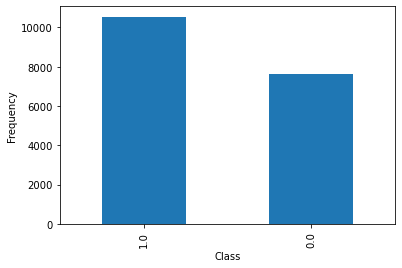

In [14]:
"""Checking columns names"""
print(df.columns)

"Checking Target of the data"
print(df['Sistem Yönü'].value_counts())
pd.value_counts(df['Sistem Yönü']).plot.bar()
plt.xlabel('Class')
plt.ylabel('Frequency')
df['Sistem Yönü'].value_counts()

"""Checking whether the data includes categorical values"""
categorical = [var for var in df.columns if df[var].dtype=='O']
print('The categorical variables are :', categorical)
df[categorical].head()

"""finding numerical variables"""
numerical = [var for var in df.columns if df[var].dtype!='O']
print('There are {} numerical variables\n'.format(len(numerical)))
print('The numerical variables are :', numerical)
df[numerical].head()


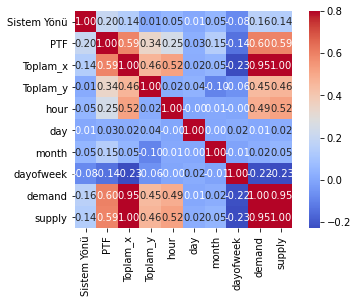

In [15]:
"Correlation matrix"
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, vmax=.8, square=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=90)
plt.show()

In [16]:
"Creating correlation matrix features without target value"
olddf = df.columns
print("Before eliminating shape: ",df.shape)
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#Keeping at least any feature in data.
to_drop = [column for column in upper.columns if any(upper[column] > 0.94)]
# Dropping index of feature columns with correlation greater than 0.95
df = df.drop(df[to_drop], axis=1)
newdf = df.columns
print("After eliminating shape: ",df.shape)
print("Eliminating features:\n",list(set(olddf) - set(newdf)))

df = df.set_index('DateTime')

Target = df['Sistem Yönü']
Target = pd.DataFrame(Target)
df = df.drop('Sistem Yönü', axis=1)

Before eliminating shape:  (18172, 11)
After eliminating shape:  (18172, 9)
Eliminating features:
 ['demand', 'supply']


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
TRAIN: [   0    1    2 ... 3029 3030 3031] VALIDATION: [3032 3033 3034 ... 6057 6058 6059]


/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


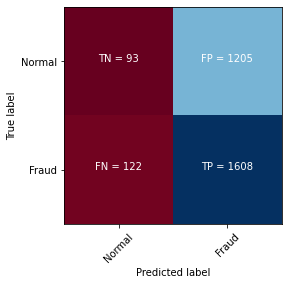

Recall=0.929 
Precision=0.572
F1=0.708
Average precision-recall score: 0.583


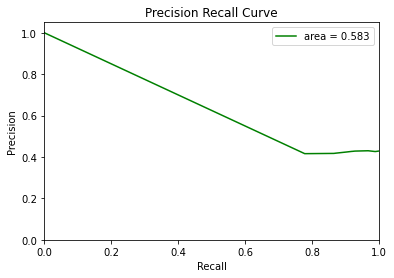

TRAIN: [   0    1    2 ... 6057 6058 6059] VALIDATION: [6060 6061 6062 ... 9085 9086 9087]


/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


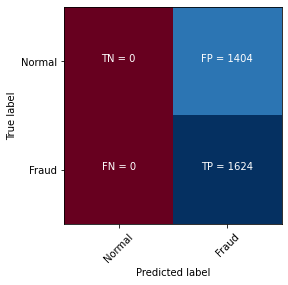

Recall=1.000 
Precision=0.536
F1=0.698
Average precision-recall score: 0.581


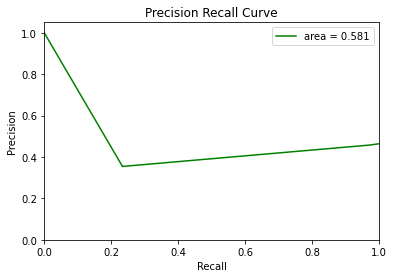

TRAIN: [   0    1    2 ... 9085 9086 9087] VALIDATION: [ 9088  9089  9090 ... 12113 12114 12115]


/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


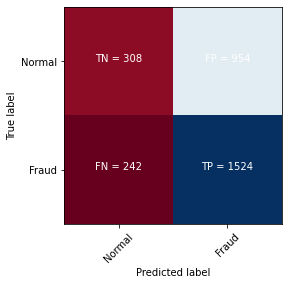

Recall=0.863 
Precision=0.615
F1=0.718
Average precision-recall score: 0.676


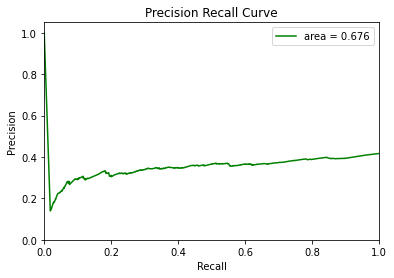

TRAIN: [    0     1     2 ... 12113 12114 12115] VALIDATION: [12116 12117 12118 ... 15141 15142 15143]


/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


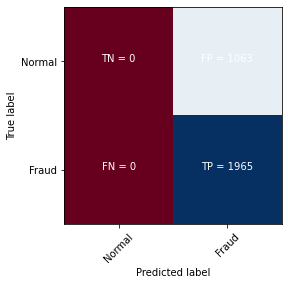

Recall=1.000 
Precision=0.649
F1=0.787
Average precision-recall score: 0.654


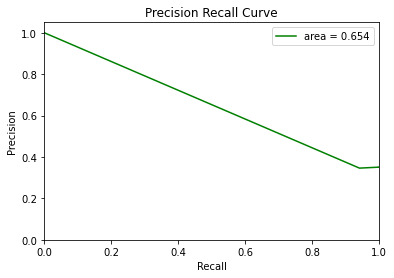

TRAIN: [    0     1     2 ... 15141 15142 15143] VALIDATION: [15144 15145 15146 ... 18169 18170 18171]


/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


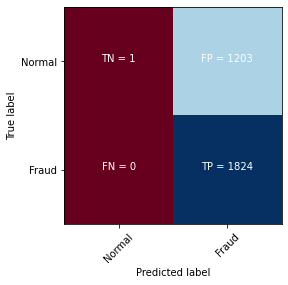

Recall=1.000 
Precision=0.603
F1=0.752
Average precision-recall score: 0.585


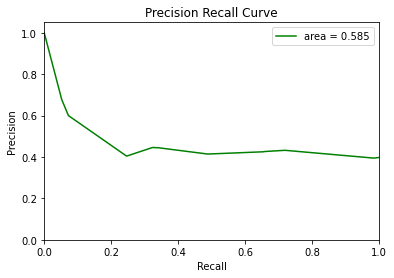

In [17]:
df = df.values
Target = Target.values

k = 0
n_splits=5
scaler = MinMaxScaler(feature_range=(0,1))

tscv = TimeSeriesSplit(max_train_size=None, n_splits=n_splits)

predictions = pd.DataFrame(columns=np.arange(0,5,1)).fillna(0)

accuracyresults = np.zeros(n_splits)
print(tscv)
for train_index, val_index in tscv.split(df):
    print("TRAIN:", train_index, "VALIDATION:", val_index)    
    X_train, X_val = df[train_index], df[val_index]
    y_train, y_val = Target[train_index], Target[val_index]
    # train_scaled = scaler.fit_transform(X_train)
    # test_scaled = scaler.fit_transform(X_val)
    # sm = SMOTE(random_state=2)
    # X_resampled_train, y_resampled_train = sm.fit_resample(X_train, y_train.ravel())
    model, predictions[k] = LGBClassifier(X_train,y_train,X_val)
    try:
        scores = model.decision_function(X_val)
    except:
        scores = model.predict_proba(X_val)[:,1]
    #Make plots
    plot_cm(model, predictions[k])
    plot_aucprc(model, scores) 
    accuracyresults[k] = metrics.accuracy_score(y_val, predictions[k])
    k = k + 1

In [18]:
#%% TEST SET

tomorrow = (datetime.now() + timedelta(1)).strftime('%Y-%m-%d')

def EPIAS_API():
    down = './test.json'
    url = 'https://seffaflik.epias.com.tr/transparency/service/production/wpp-generation-and-forecast?endDate={}&startDate={}'.format(tomorrow,tomorrow)
    outpath=down
    generatedURL=url
    response = requests.get(generatedURL)
    if response.status_code == 200:
        with open(outpath, "wb") as out:
            for chunk in response.iter_content(chunk_size=128):
                out.write(chunk)
    with open(down) as json_file:
        data = json.load(json_file)
        
    body=data.get('body')
    gen=body.get('data')
    df=pd.DataFrame(gen)
    return df

X_test = EPIAS_API()

#%% Electricity Prices

ptf2 = gop.ptf(baslangic_tarihi = tomorrow, bitis_tarihi = tomorrow)
ptf2['DateTime'] = pd.to_datetime(ptf2.Tarih) + ptf2.Saat.astype('timedelta64[h]')
ptf2 = ptf2.set_index('DateTime')
ptf2 = pd.DataFrame(ptf2['PTF'])

#%% Final Daily Production

kgup3 = uretim.kgup(baslangic_tarihi = tomorrow, bitis_tarihi = tomorrow)
kgup3['DateTime'] = pd.to_datetime(kgup3.Tarih) + kgup3.Saat.astype('timedelta64[h]')
kgup3 = kgup3.set_index('DateTime')
kgup3 = pd.DataFrame(kgup3['Toplam'])

#%% Available Installed Capacity

eak3 = uretim.eak(baslangic_tarihi = tomorrow, bitis_tarihi = tomorrow)
eak3['DateTime'] = pd.to_datetime(eak3.Tarih) + eak3.Saat.astype('timedelta64[h]')
eak3 = eak3.set_index('DateTime')
eak3 = pd.DataFrame(eak3['Toplam'])

X_test = pd.merge(ptf2, kgup3, on="DateTime", how="outer")
X_test = pd.merge(X_test, eak3, on="DateTime", how="outer")
X_test = X_test.reset_index(drop=False)

X_test['hour'] = pd.DatetimeIndex(X_test['DateTime']).hour
X_test['day'] = pd.DatetimeIndex(X_test['DateTime']).day
X_test['month'] = pd.DatetimeIndex(X_test['DateTime']).month
X_test['dayofweek'] = pd.DatetimeIndex(X_test['DateTime']).dayofweek

X_test = X_test.set_index('DateTime')

X_test = X_test.values
modeltest, result = LGBClassifier(X_train,y_train,X_test)

print(result)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
